# Mecklin polyp risk
Transform Mecklin polyp risk data to usable endpoints for analysis. Data originally extracted using PlotDigitizer online app. Data for Lynch Syndrome patients, broken down by male and female. Not gene-specific.

In [40]:
import sys
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from csaps import csaps

PARENT_DIR = "/Users/sophiewagner/repos/lynch-syndrome"
DATA_DIR = os.path.join(PARENT_DIR, "data")

In [41]:
# Load data
file_path = os.path.join(DATA_DIR, "polyps.xlsx")
mecklin = pd.read_excel(file_path, sheet_name="mecklin_2007_km")

In [42]:
# Extract data from sheet
data = mecklin.iloc[2:139,1:-2].reset_index(drop=True)
data.columns = ['sex', 'val_type', 'age','val']
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['val'] = pd.to_numeric(data['val'], errors='coerce')
data.head()

,sex,val_type,age,val
0,female,lower,24.755583,0.007065
1,female,lower,39.158271,0.003265
2,female,lower,41.389655,0.037643
3,female,lower,42.337443,0.063084
4,female,lower,44.925582,0.076740


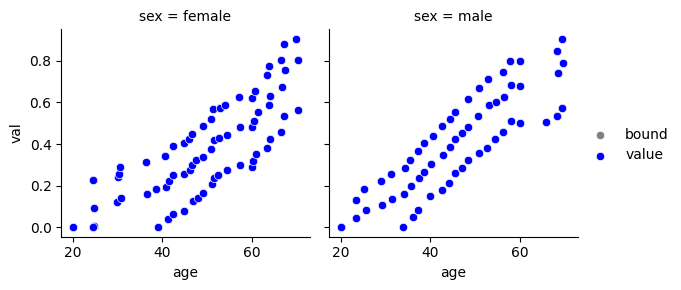

In [ ]:
import seaborn as sns
g = sns.FacetGrid(data, col='sex')
for val_type, group in data.groupby('val_type'):
    if val_type =='value':
        g.map(sns.scatterplot, 'age', 'val', label='value', color='lightblue')
    else: 
        g.map(sns.scatterplot, 'age', 'val', label='bound', color='grey')
g.add_legend()
plt.show()


In [91]:
def extract_csaps(data, sex, val_type, smooth=0.1):
    d = data.loc[
        (data['sex'] == sex) & 
        (data['val_type'] == val_type)
    ][['age', 'val']].copy()

    # Add dummy point
    dummy = pd.DataFrame({'age': 75, 'val': d['val'].max() * 1.05}, index=[0])
    d = pd.concat([d, dummy], ignore_index=True)

    # Group by age to ensure strictly increasing x
    d = d.groupby('age', as_index=False).mean().sort_values('age').reset_index(drop=True)

    # Fit spline
    spline = csaps(d['age'], d['val'], smooth=smooth)
    x = np.arange(20, 75, 1)
    y = spline(x).clip(0, 1)
    y = np.maximum.accumulate(y)  # Ensure monotonic
    return y


In [92]:
ages = np.arange(20, 75, 1)
df = pd.DataFrame({
    'sex': ['female'] * len(ages) + ['male'] * len(ages),
    'age': np.tile(ages, 2)  # repeat age array for each sex
})

# Extract values for each sex and concatenate
df_female = pd.DataFrame({
    'value': extract_csaps(data, 'female', 'value', smooth=0.01),
    'lower': extract_csaps(data, 'female', 'lower', smooth=0.01),
    'upper': extract_csaps(data, 'female', 'upper', smooth=0.01)
}, index=range(len(ages)))

df_female['value'] = np.maximum(df_female['lower'], df_female['value'])
df_female['upper'] = np.maximum(df_female['value'], df_female['upper'])

df_male = pd.DataFrame({
    'value': extract_csaps(data, 'male', 'value', smooth=0.01),
    'lower': extract_csaps(data, 'male', 'lower', smooth=0.01),
    'upper': extract_csaps(data, 'male', 'upper', smooth=0.01)
},index=range(len(ages)))
df_male['value'] = np.maximum(df_male['lower'], df_male['value'])
df_male['upper'] = np.maximum(df_male['value'], df_male['upper'])
# Combine extracted values back into df
df[['value', 'lower', 'upper']] = pd.concat([df_female, df_male], ignore_index=True)


In [93]:
ages = np.arange(20, 75, 1)

# Step 1: Setup base DataFrame
df_clippy = pd.DataFrame({
    'sex': ['female'] * len(ages) + ['male'] * len(ages),
    'age': np.tile(ages, 2)
})

# Step 2: Clip source data
data_clip = data.loc[data['age'] <= 60].copy()

# Step 3: Add dummy points for both sexes
for sex in ['male', 'female']:
    for val_type in ['value']:
        max_val = data_clip.loc[(data_clip['sex'] == sex) & (data_clip['val_type'] == val_type), 'val'].max()
        dummy = pd.DataFrame({'age': 75, 'sex': sex, 'val_type': val_type, 'val': max_val * 1.05}, index=[0])
        data_clip = pd.concat([data_clip, dummy], ignore_index=True)

# Step 4: Sort
data_clip = data_clip.sort_values(['sex', 'age']).reset_index(drop=True)

# Step 5: Interpolate for each sex
df_female_clip = pd.DataFrame({
    'value': extract_csaps(data_clip, 'female', 'value', smooth=0.01),
    'lower': extract_csaps(data_clip, 'female', 'lower', smooth=0.01),
    'upper': extract_csaps(data_clip, 'female', 'upper', smooth=0.01)
}, index=range(len(ages)))

df_female_clip['value'] = np.maximum(df_female_clip['lower'], df_female_clip['value'])
df_female_clip['upper'] = np.maximum(df_female_clip['value'], df_female_clip['upper'])

df_male_clip = pd.DataFrame({
    'value': extract_csaps(data_clip, 'male', 'value', smooth=0.01),
    'lower': extract_csaps(data_clip, 'male', 'lower', smooth=0.01),
    'upper': extract_csaps(data_clip, 'male', 'upper', smooth=0.01)
}, index=range(len(ages)))

df_male_clip['value'] = np.maximum(df_male_clip['lower'], df_male_clip['value'])
df_male_clip['upper'] = np.maximum(df_male_clip['value'], df_male_clip['upper'])

# Step 6: Combine
df_combined_clip = pd.concat([df_female_clip, df_male_clip], ignore_index=True)
df_clippy[['value', 'lower', 'upper']] = df_combined_clip.reset_index(drop=True)


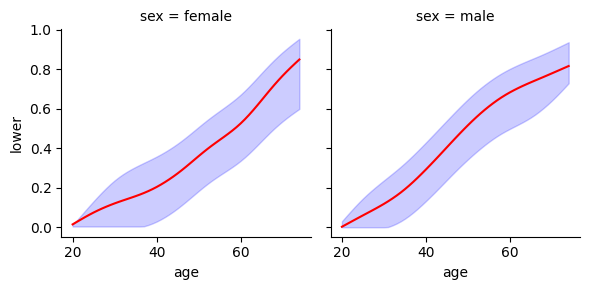

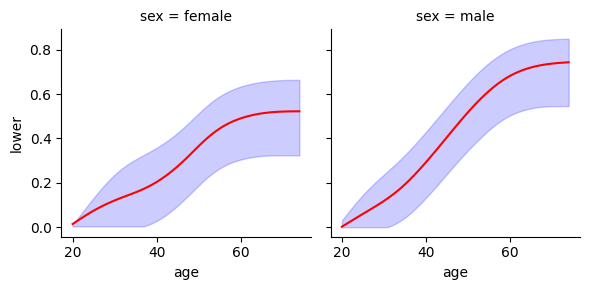

In [95]:
import seaborn as sns
g = sns.FacetGrid(df, col='sex', col_wrap=2)
g.map(plt.plot, 'age', 'value', color='red')
g.map(plt.fill_between, 'age', 'lower', 'upper', color='blue', alpha=0.2)
plt.show()

g_clip = sns.FacetGrid(df_clippy, col='sex', col_wrap=2)
g_clip.map(plt.plot, 'age', 'value', color='red')
g_clip.map(plt.fill_between, 'age', 'lower', 'upper', color='blue', alpha=0.2)
plt.show()

In [114]:
from scipy.optimize import curve_fit
df['se'] = (df['upper'] - df['lower']) / (1.96*2)
def plot_logistic(data, sex):
    def logistic(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    d = df.loc[df['sex']==sex]
    p0 = [d['value'].max(), 0.1, 50]
    sigma= d['se'].values
    
    init_fit = logistic(ages, *p0)
    params, _ = curve_fit(logistic, ages, d['value'], p0=p0, sigma=sigma, absolute_sigma=True)
    risk_fit = logistic(ages, *params)
    
    plt.plot(ages, d['value'], 'o', label=f'{sex} risk')
    plt.plot(ages, init_fit, 'r--', label='Initial fit')
    plt.plot(ages, risk_fit, 'g-', label='Fitted logistic curve')
    plt.xlabel("Age")
    plt.ylabel("Cumulative polyp Risk")
    plt.title(f"Smooth Fit of polyp Cumulative Risk ({sex})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return risk_fit

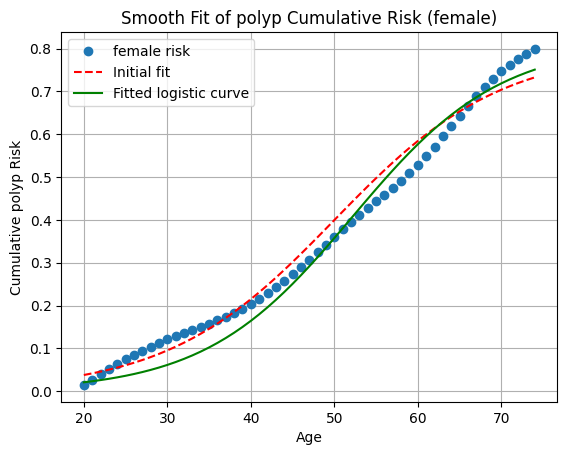

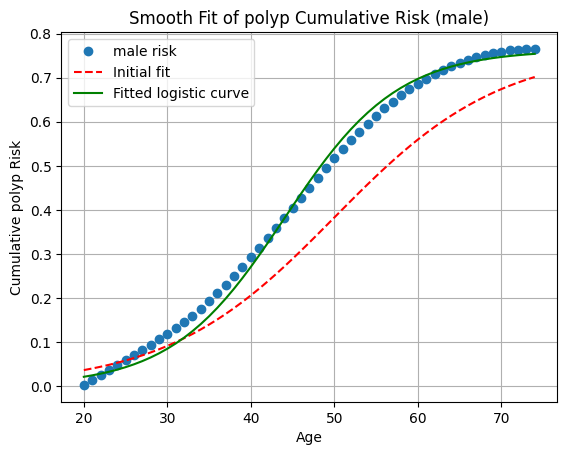

In [120]:
polyp_risk_fit = {}
polyp_risk_fit['age'] = ages
polyp_risk_fit['female'] = plot_logistic(df, 'female')
polyp_risk_fit['male'] = plot_logistic(df, 'male')

In [118]:
print(polyp_risk_fit['female'][-1])
print(polyp_risk_fit['male'][-1])

0.7508126716588613
0.7542192180583569


In [121]:
pd.DataFrame(polyp_risk_fit).to_csv(os.path.join(DATA_DIR, "mecklin_polyp_risk_1y.csv"), index=False)

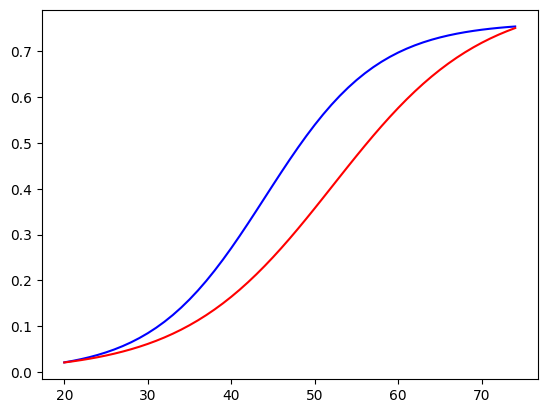

In [122]:
plt.plot(ages, polyp_risk_fit['male'], color='blue')
plt.plot(ages, polyp_risk_fit['female'], color='red')

# Myles gene-specific polyp risk

In [48]:
myles_risk = pd.read_excel(file_path, sheet_name="Myles_Adenoma_Risk_Gene")
myles_risk = myles_risk.iloc[2:30,1:-1]
myles_risk.columns = ['age_MSH2', 'MSH2', 'age_MLH1', 'MLH1', 'age_PMS2', 'PMS2', 'age_MSH6', 'MSH6']

# Create long-form dataframe by melting each gene pair and appending
dfs = []

for gene in ['MSH2', 'MLH1', 'PMS2', 'MSH6']:
    df_long = myles_risk[[f'age_{gene}', gene]].copy()
    df_long.columns = ['age', 'value']
    df_long['gene'] = gene
    dfs.append(df_long)

# Concatenate all gene-specific long dataframes
myles_risk_long = pd.concat(dfs, ignore_index=True)

# Clean up types
myles_risk_long['age'] = pd.to_numeric(myles_risk_long['age'], errors='coerce')
myles_risk_long['value'] = pd.to_numeric(myles_risk_long['value'], errors='coerce')

myles_risk_long.dropna(inplace=True)  # Remove any rows with NaN values
myles_risk_long


,age,value,gene
0,25.0000,1.000000e-07,MSH2
1,40.6372,1.047000e+00,MSH2
2,41.2743,4.487000e+00,MSH2
3,42.1947,1.004800e+01,MSH2
4,43.1150,1.427900e+01,MSH2
...,...,...,...
103,55.3042,5.629600e+01,MSH6
104,56.7500,5.680700e+01,MSH6
105,57.9492,5.705600e+01,MSH6
106,58.7573,6.155500e+01,MSH6


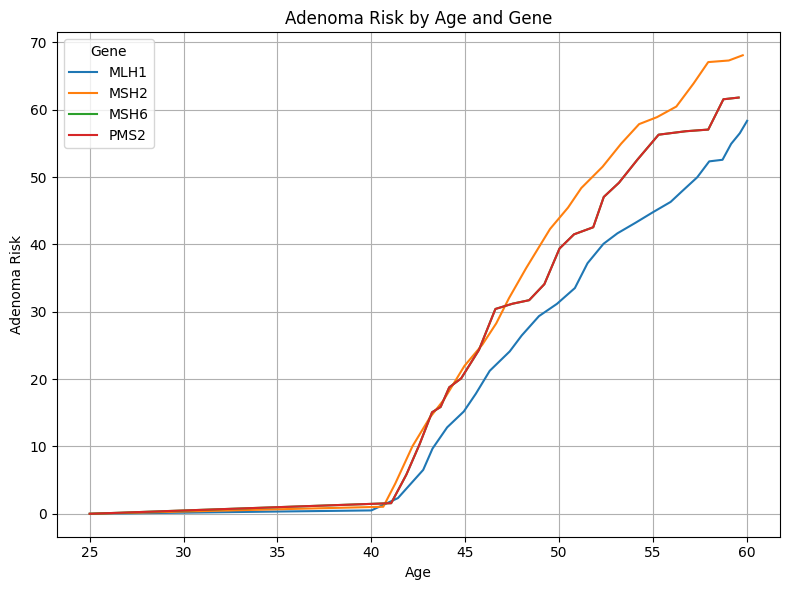

In [49]:
plt.figure(figsize=(8, 6))

# Loop through each gene and plot separately
for gene, group in myles_risk_long.groupby('gene'):
    plt.plot(group['age'], group['value'], label=gene)

# Add labels and legend
plt.xlabel('Age')
plt.ylabel('Adenoma Risk')
plt.title('Adenoma Risk by Age and Gene')
plt.legend(title='Gene')
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
def extract_csaps_gene(data, gene, smooth=0.1):
    d = data.loc[
        (data['gene']==gene)
        ]
    dummy = pd.DataFrame({'age':75, 'value':d['value'].max()*0.95}, index=[0]) # add dummy point
    d = pd.concat([d, dummy], ignore_index=True)
    d = d.sort_values('age').reset_index(drop=True)
    spline = csaps(d['age'], d['value'], smooth=smooth)
    x = np.arange(20, 75, 1)
    y = spline(x).clip(0.0001,100)
    y = np.maximum.accumulate(y)
    return y

ages = np.arange(20, 75, 1)
myles_polyp_smoothed = pd.DataFrame()
myles_polyp_smoothed['age'] = ages
for gene in ['MLH1', 'MSH2', 'MSH6', 'PMS2']:
    myles_polyp_smoothed[gene] = extract_csaps_gene(myles_risk_long, gene, smooth=0.01)

myles_polyp_smoothed = pd.melt(myles_polyp_smoothed, id_vars='age', var_name='gene', value_name='value')

In [72]:
myles_polyp_smoothed

,age,gene,value
0,20,MLH1,0.007600
1,21,MLH1,0.007600
2,22,MLH1,0.007600
3,23,MLH1,0.007600
4,24,MLH1,0.007600
...,...,...,...
215,70,PMS2,64.454003
216,71,PMS2,64.454003
217,72,PMS2,64.454003
218,73,PMS2,64.454003


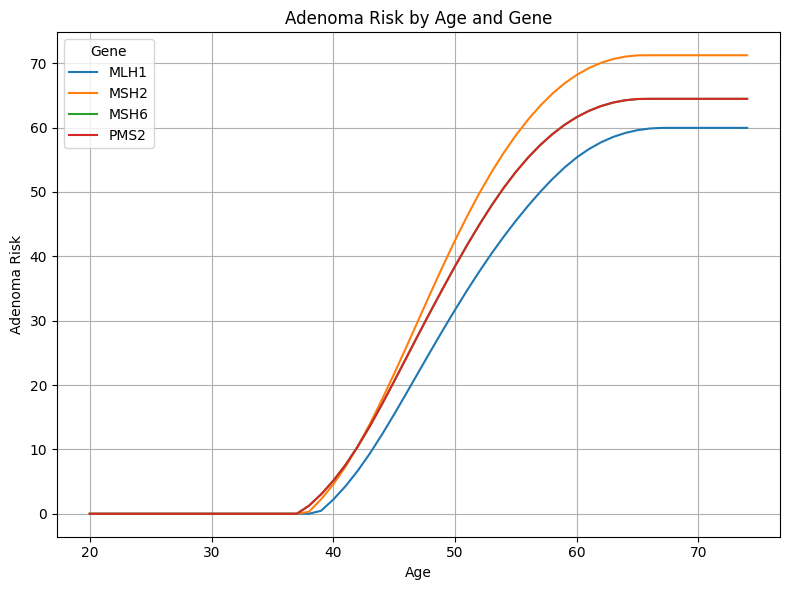

In [73]:
plt.figure(figsize=(8, 6))

for gene, group in myles_polyp_smoothed.groupby('gene'):
    plt.plot(group['age'], group['value'], label=gene)

# Add labels and legend
plt.xlabel('Age')
plt.ylabel('Adenoma Risk')
plt.title('Adenoma Risk by Age and Gene')
plt.legend(title='Gene')
plt.grid(True)
plt.tight_layout()
plt.show()